# GLM HMM with EM on Simulated Data

In [43]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from SyntheticHMM import *
import ssm

## Set up Data

In [44]:
def plot_psychometric(clf, coefs=None):
    oldcoef = clf.coef_
    oldintercept = clf.intercept_
    if not (coefs is None):
        clf.coef_ = np.array([coefs[0,:-1]])
        clf.intercept_ = np.array([coefs[0,-1]])
    data_prevl = []
    data_prevr = []
    for delta in range(-35,36):
        data_prevl.append([0,delta])
        data_prevr.append([1,delta])
    data_prevl = np.array(data_prevl)
    data_prevr = np.array(data_prevr)
    psychometric_curve_prevl = clf.predict_proba(data_prevl)
    psychometric_curve_prevr = clf.predict_proba(data_prevr)
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevl[:,1], color="blue",
        label="Previous Choice Left"
        )
    plt.plot(
        range(-35, 36),
        psychometric_curve_prevr[:,1], color="red",
        label="Previous Choice Right"
        )
    plt.title("Probability of Choosing Right")
    plt.legend()
    plt.xlabel("More Left Beeps >>> More Right Beeps")
    plt.show()
    clf.coef_ = oldcoef
    clf.intercept_ = oldintercept

In [45]:
train_size = 400
test_size = 120

In [46]:
# Synthetic: X_train, X_test
X_train = np.random.choice(np.arange(-30,31,1), size=train_size).reshape((-1,1))
X_test = np.random.choice(np.arange(-30,31,1), size=test_size).reshape((-1,1))

In [47]:
K = 2 # Number of states
D = 1 # Dimension of observations

In [98]:
# Synthetic GLM states
K = 3
true_K = 3
set_coef = np.array(
    [[0.01, 0.08, 0.02],
     [1., 0.04, -0.50],
     [-1., 0.04, -0.50]]
    )

## Generate Synthetic Data

In [99]:
transition_coefs = np.random.rand(K, set_coef.shape[1])*0
true_hmm = SyntheticInputDrivenGLMHMM(
    K, set_coef, transition_coefs
    )

In [70]:
# Generate simulated data
sim_states_train, sim_y_train = true_hmm.sample(X_train)
sim_states_test, sim_y_test = true_hmm.sample(X_test)
sim_y_train = sim_y_train.astype(int)
sim_y_test = sim_y_test.astype(int)
sim_X_test = np.hstack((sim_y_test[:-1], X_test[1:].copy()))
sim_X_train = np.hstack((sim_y_train[:-1], X_train[1:].copy()))
sim_y_test = sim_y_test[1:]
sim_y_train = sim_y_train[1:]

## Fitting HMM and checking inferred transition matrix

In [73]:
def fit_hmm(
    K, X_train, y_train,
    sim_X_test, sim_y_test, transitions="standard"
    ):
    fitted_lls = []
    best_test_ll = -np.inf
    best_ll_array = None
    best_hmm = None
    input_size = X_train.shape[1]
    for _ in range(15):
        tmp_hmm = ssm.HMM(
            K, D, M=input_size, observations="logistic",
            transitions=transitions,
            observation_kwargs={"input_size":input_size}
            )
        lls = tmp_hmm.fit(
            y_train,
            inputs=X_train,
            method="em"
            )
        test_ll = tmp_hmm.log_likelihood(sim_y_test, inputs=sim_X_test)
        if test_ll > best_test_ll:
            best_test_ll = test_ll
            best_ll_array = lls
            best_hmm = tmp_hmm
    hmm = best_hmm
    lls = best_ll_array
    return hmm, lls, best_test_ll

In [74]:
%%capture
Ks = [2]
K_hmms = []
K_lls = []
K_test_lls = []
for K in Ks:
    _hmm, _lls, _test_ll = fit_hmm(
        K, sim_X_train, sim_y_train,
        sim_X_test, sim_y_test,
        transitions="standard"
        )
    K_hmms.append(_hmm)
    K_lls.append(_lls)
    K_test_lls.append(_test_ll)

## Comparing inferred psychometric curves

In [75]:
hmm = K_hmms[Ks.index(true_K)]

In [76]:
%%capture
clf = LogisticRegression().fit(sim_X_train, sim_y_train)

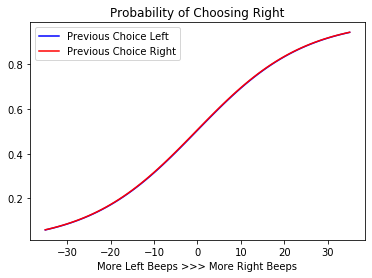

In [56]:
plot_psychometric(clf, true_hmm.coefs[0,:].reshape((1,-1)))

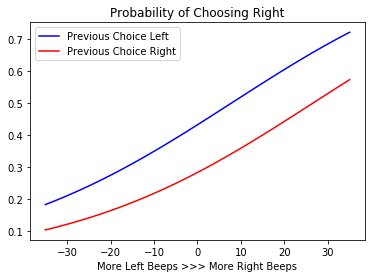

In [81]:
plot_psychometric(clf, hmm.observations.coef[1,:].reshape((1,-1)))

In [59]:
 hmm.observations.coef

array([[ 0.01347069,  0.08247031,  1.13431769],
       [-1.23114869,  0.01001895, -0.94957744]])

In [60]:
set_coef

array([[ 0.01,  0.08,  0.02],
       [ 1.  ,  0.04, -0.5 ]])

## Testing accuracy: predicted states and predicted choices

In [87]:
hmm.most_likely_states(sim_y_test, input=sim_X_test)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0])

In [97]:
253/400

0.6325

In [96]:
sim_states_train.size

400

In [95]:
np.sum(np.equal(hmm.most_likely_states(sim_y_train, input=sim_X_train), sim_states_train[1:]))

253

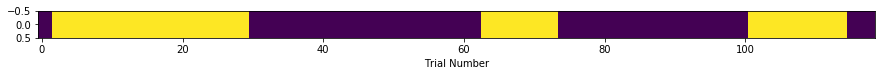

In [79]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    hmm.most_likely_states(sim_y_test, input=sim_X_test).reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()

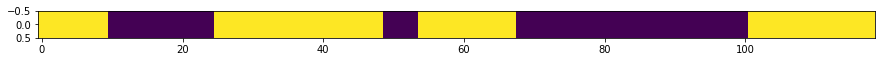

In [92]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    sim_states_test[1:].reshape((1,-1)),
    aspect="auto")
plt.show()

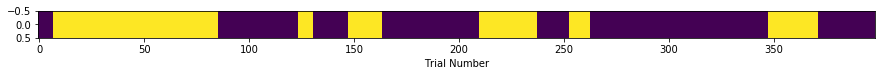

In [80]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    hmm.most_likely_states(sim_y_train, input=sim_X_train).reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()

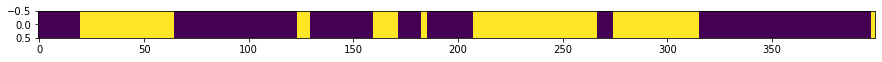

In [72]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    sim_states_train[:400].reshape((1,-1)),
    aspect="auto")
plt.show()

In [ ]:
print("Proportion Identical")
print(np.sum(predicted.astype(bool) == sim_z_test.astype(bool))/predicted.size)
print(np.sum(np.logical_not(predicted.astype(bool)) == sim_z_test.astype(bool))/predicted.size)

## Data size sensitivitiy: likelihood/data point

In [98]:
def fit_hmm_datasize(train_size):
    test_size = 100
    X_train = np.random.choice(np.arange(-30,31,1), size=train_size).reshape((-1,1))
    X_test = np.random.choice(np.arange(-30,31,1), size=test_size).reshape((-1,1))
    transition_coefs = np.random.rand(true_K, set_coef.shape[1])*2
    true_hmm = SyntheticInputDrivenGLMHMM(
        true_K, set_coef, transition_coefs
        )
    # Generate simulated data
    sim_states_train, sim_y_train = true_hmm.sample(X_train)
    sim_states_test, sim_y_test = true_hmm.sample(X_test)
    sim_y_train = sim_y_train.astype(int)
    sim_y_test = sim_y_test.astype(int)
    sim_X_test = np.hstack((sim_y_test[:-1], X_test[1:].copy()))
    sim_X_train = np.hstack((sim_y_train[:-1], X_train[1:].copy()))
    sim_y_test = sim_y_test[1:]
    sim_y_train = sim_y_train[1:]
    hmm, lls, test_ll = fit_hmm(
        true_K, sim_X_train, sim_y_train,
        sim_X_test, sim_y_test, transitions="inputdriven")
    result = {}
    result['hmm'] = hmm
    result['lls'] = lls
    result['test_ll'] = test_ll
    result['sim_X_train'] = sim_X_train
    result['sim_y_train'] = sim_y_train
    result['sim_X_test'] = sim_X_test
    result['sim_y_test'] = sim_y_test
    return result

In [99]:
%%capture
train_sizes = np.arange(300,800,50)
results = []
for train_size in train_sizes:
    result = fit_hmm_datasize(train_size)
    results.append(result)

In [101]:
results[0]['test_ll']

-54.02498193194144

In [102]:
K_datasize_lls

[]

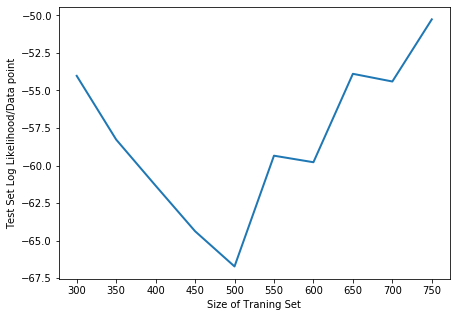

In [103]:
K_datasize_lls = []
for result in results:
    K_datasize_lls.append(result['test_ll'])
plt.figure(figsize=(7,5))
plt.plot(train_sizes, K_datasize_lls, linewidth=2)
plt.xlabel("Size of Traning Set")
plt.ylabel("Test Set Log Likelihood/Data point")
plt.xticks(train_sizes)
plt.show()

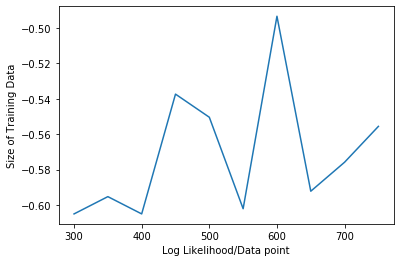

In [46]:
datasize_max_lls = [max(ll) for ll in datasize_lls]
plt.xlabel("Log Likelihood/Data point")
plt.ylabel("Size of Training Data")
plt.plot(train_sizes, datasize_max_lls/train_sizes)

In [123]:
hmm = results[np.argwhere(train_sizes == 500)[0,0]]['hmm']

In [47]:
np.argwhere(train_sizes == 600)[0,0]

6